In [22]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import emcee
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time
import lightkurve as lk

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
df = pd.read_csv('../data/preliminary_results.csv')

In [3]:
df

,date,ew,ew_unc,file_basename,full_filepath,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,star_name,time
0,2020-07-16,1.395743,1.181927e-02,Goldilocks_20200716T094818_v1.0_0033.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.106646,8.985081e-03,8542.0,2.459047e+06,5000.0,8.542580e+03,5.904067e-03,6245.0,HAT-P-11,09:48:47
1,2020-07-16,1.393962,1.222317e-02,Goldilocks_20200716T095404_v1.0_0034.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.105402,9.202246e-03,8542.0,2.459047e+06,5000.0,8.542570e+03,6.376022e-03,6245.0,HAT-P-11,09:54:28
2,2020-07-24,1.363680,1.153400e-02,Goldilocks_20200724T094542_v1.0_0025.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.020919,8.568031e-03,8542.0,2.459055e+06,5000.0,8.542622e+03,5.690058e-03,7146.0,HAT-P-11,09:46:12
3,2020-07-24,1.353340,1.179830e-02,Goldilocks_20200724T095128_v1.0_0026.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.016422,8.953680e-03,8542.0,2.459055e+06,5000.0,8.542621e+03,6.048049e-03,7146.0,HAT-P-11,09:51:53
4,2020-08-01,1.350427,1.515268e-02,Goldilocks_20200801T030803_v1.0_0004.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-11b\P4\G...,1.006933,1.134170e-02,8542.0,2.459063e+06,5000.0,8.542646e+03,7.465504e-03,7226.0,HAT-P-11,03:08:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2019-10-22,-0.691427,2.336325e-02,Goldilocks_20191022T020027_v1.0_0006.spectra.fits,../data/HPF/Helium-transit-data\WASP-69b\out-o...,1.343556,2.878386e-02,8542.0,2.458779e+06,5000.0,8.541701e+03,3.355662e-02,NaN,WASP_69_out_1_after_4,02:00:52
401,2020-07-23,17.731751,2.055538e+00,Goldilocks_20200723T055838_v1.0_0006.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,7.572096,1.366191e+00,8542.0,2.459054e+06,5000.0,8.534557e+03,1.348364e+00,7144.0,WASP-80,05:59:07
402,2020-07-23,804957.885020,4.804489e+06,Goldilocks_20200723T060741_v1.0_0007.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,990695.465321,5.882518e+06,8542.0,2.459054e+06,5000.0,-8.794204e+07,1.864819e+09,7144.0,WASP-80,06:08:11
403,2020-08-01,-1.055729,1.344991e-01,Goldilocks_20200801T052720_v1.0_0023.spectra.fits,../data/HPF/Helium-transit-data\WASP-80b\Goldi...,1.575354,8.242386e-02,8542.0,2.459063e+06,5000.0,8.540966e+03,9.178269e-02,7224.0,WASP-80,05:27:48


In [4]:
df.star_name.value_counts()

HAT-P-67b_IN_1              14
HAT-P-67b_IN_2              14
HAT-P-17b_IN_1b             11
HAT-P-17b_IN_3              10
HAT-P-67b_IN_3               9
                            ..
k2-141_p4                    2
HAT-P-18b_P2_OUT_before2     1
WASP_69_out_2_before_1       1
Tres-1b_3_same               1
HAT-P-32_2_OUT_b1            1
Name: star_name, Length: 92, dtype: int64

We retrieved the data for the planets from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/)

In [5]:
target_name = 'HAT-P-67'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c-2457000.0 #neg value means discovered before TESS

In [6]:
target_mask = df.star_name.str.contains(target_name)
df = df[target_mask]
keep_mask = df.ew_unc < 10 #original value = 1

In [7]:
df

,date,ew,ew_unc,file_basename,full_filepath,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,star_name,time
158,2020-04-28,17.197802,2.270254,Goldilocks_20200428T061002_v1.0_0008.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\in-t...,7.714900,1.271535,8542.0,2.458968e+06,5000.0,8534.082881,1.248851,6437.0,HAT-P-67b_IN_1,06:10:31
159,2020-04-28,14.940468,3.382155,Goldilocks_20200428T061548_v1.0_0009.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\in-t...,6.467460,1.722693,8542.0,2.458968e+06,5000.0,8535.366902,1.731632,6437.0,HAT-P-67b_IN_1,06:16:12
160,2020-04-28,-0.635988,0.518351,Goldilocks_20200428T062128_v1.0_0010.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\in-t...,0.763609,0.182162,8542.0,2.458968e+06,5000.0,8541.164294,0.170944,6437.0,HAT-P-67b_IN_1,06:21:53
161,2020-04-28,16.621287,1.952871,Goldilocks_20200428T062708_v1.0_0011.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\in-t...,7.379331,1.120811,8542.0,2.458968e+06,5000.0,8534.385885,1.097494,6437.0,HAT-P-67b_IN_1,06:27:34
162,2020-04-28,17.775723,2.296507,Goldilocks_20200428T063248_v1.0_0012.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\in-t...,8.037958,1.269116,8542.0,2.458968e+06,5000.0,8533.817761,1.248502,6437.0,HAT-P-67b_IN_1,06:33:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2020-06-16,9.138107,61.377540,Goldilocks_20200616T090804_v1.0_0005.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\out-...,3.896730,2.222321,8542.0,2.459017e+06,5000.0,8538.244089,2.290468,6940.0,HAT-P-67b_OUT_3_after1,09:08:30
239,2020-06-18,-0.807420,0.052936,Goldilocks_20200618T085806_v1.0_0001.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\out-...,1.187137,0.046062,8542.0,2.459019e+06,5000.0,8541.177987,0.056341,6942.0,HAT-P-67b_OUT_3_after2,08:58:34
240,2020-06-18,13.580725,105.855843,Goldilocks_20200618T090346_v1.0_0002.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\out-...,5.438606,2.402734,8542.0,2.459019e+06,5000.0,8536.737815,2.444095,6942.0,HAT-P-67b_OUT_3_after2,09:04:15
241,2020-06-18,-0.772494,8.587426,Goldilocks_20200618T090932_v1.0_0003.spectra.fits,../data/HPF/Helium-transit-data\HAT-P-67b\out-...,1.392976,0.255041,8542.0,2.459019e+06,5000.0,8540.880455,0.286763,6942.0,HAT-P-67b_OUT_3_after2,09:09:56


In [8]:
df = df[keep_mask]
in_transit_mask = df.star_name.str.contains('_IN')

In [9]:
df['ew']=df.ew.astype(np.float).values #change str to float
df['btjd']=df['jd']-2457000.0 #cut down JD to smaller scale

In [10]:
sn_ratio=2
good_data_mask=(df.ew/df.ew_unc)>sn_ratio #signal to noise ratio

In [11]:
df=df[good_data_mask]

In [12]:
x_line=df['ew'].median() #calculate horizontal line going between in/out of transit points
x_line

18.12748894184838

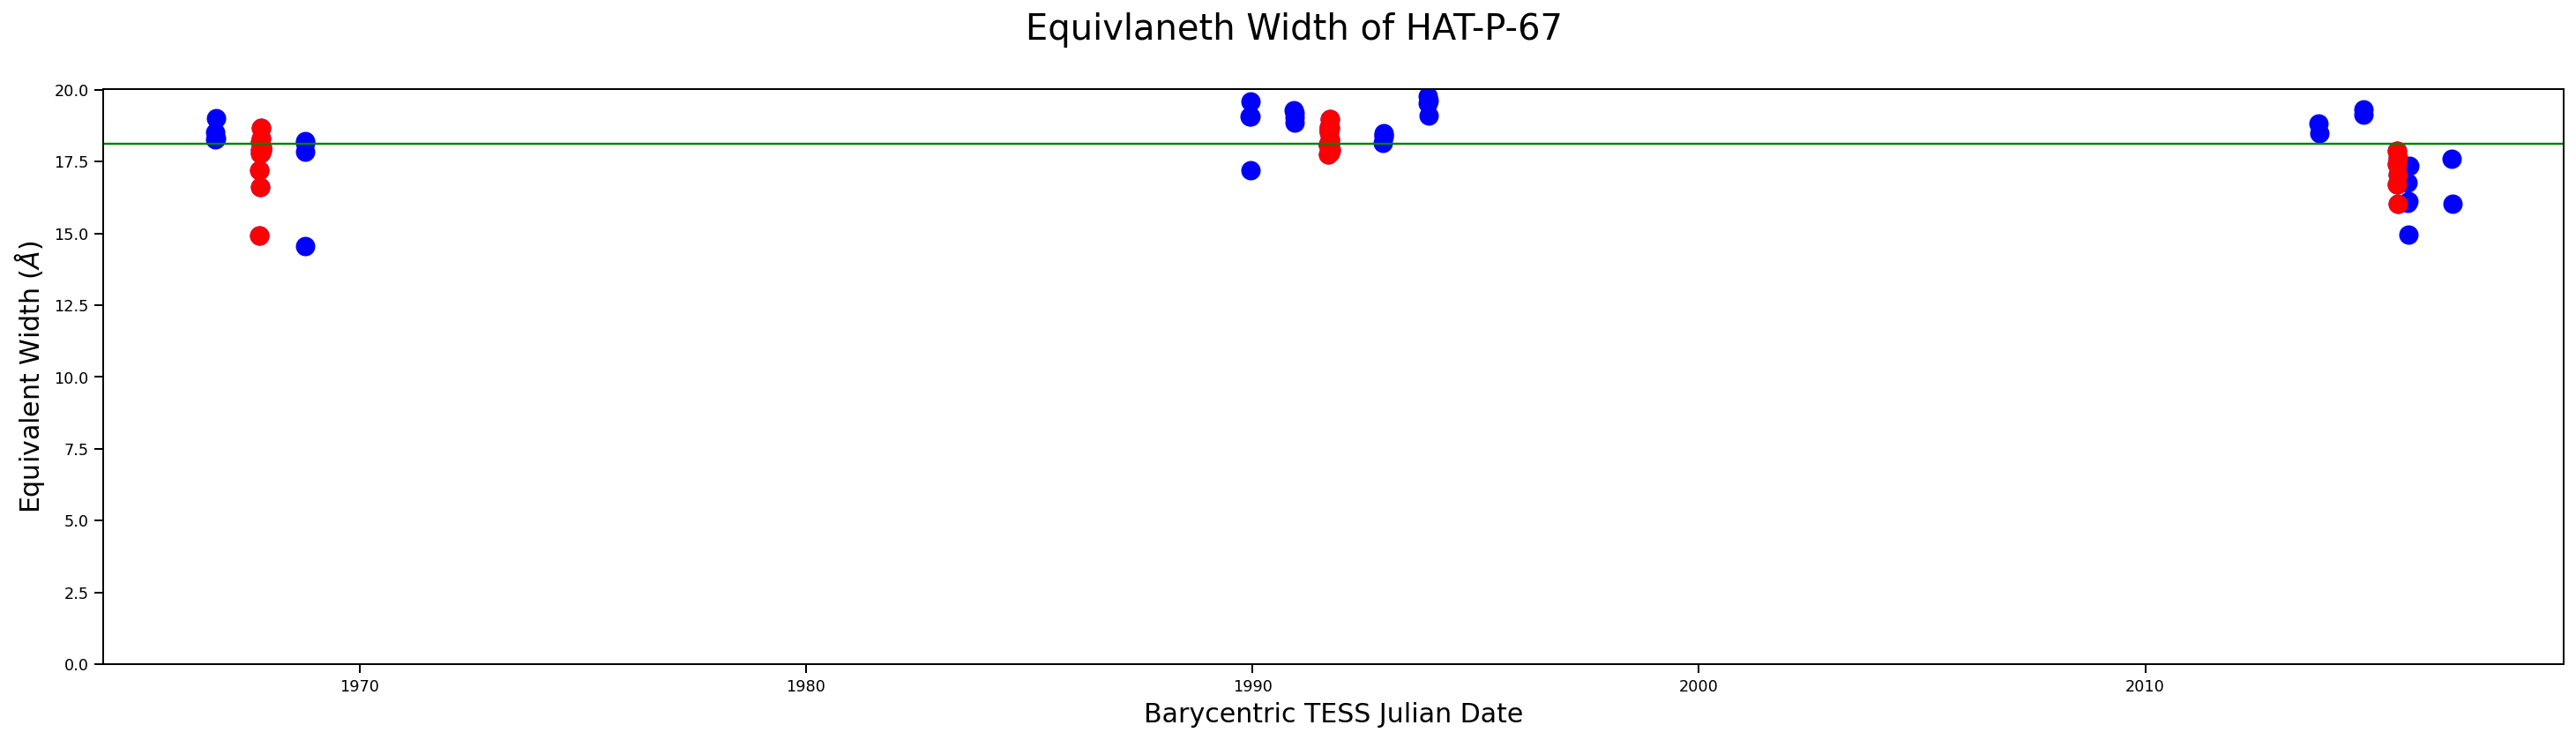

In [13]:
plt.figure(figsize=(25,6))
#plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd, df.ew, 'bo', markersize=10)
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(0)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

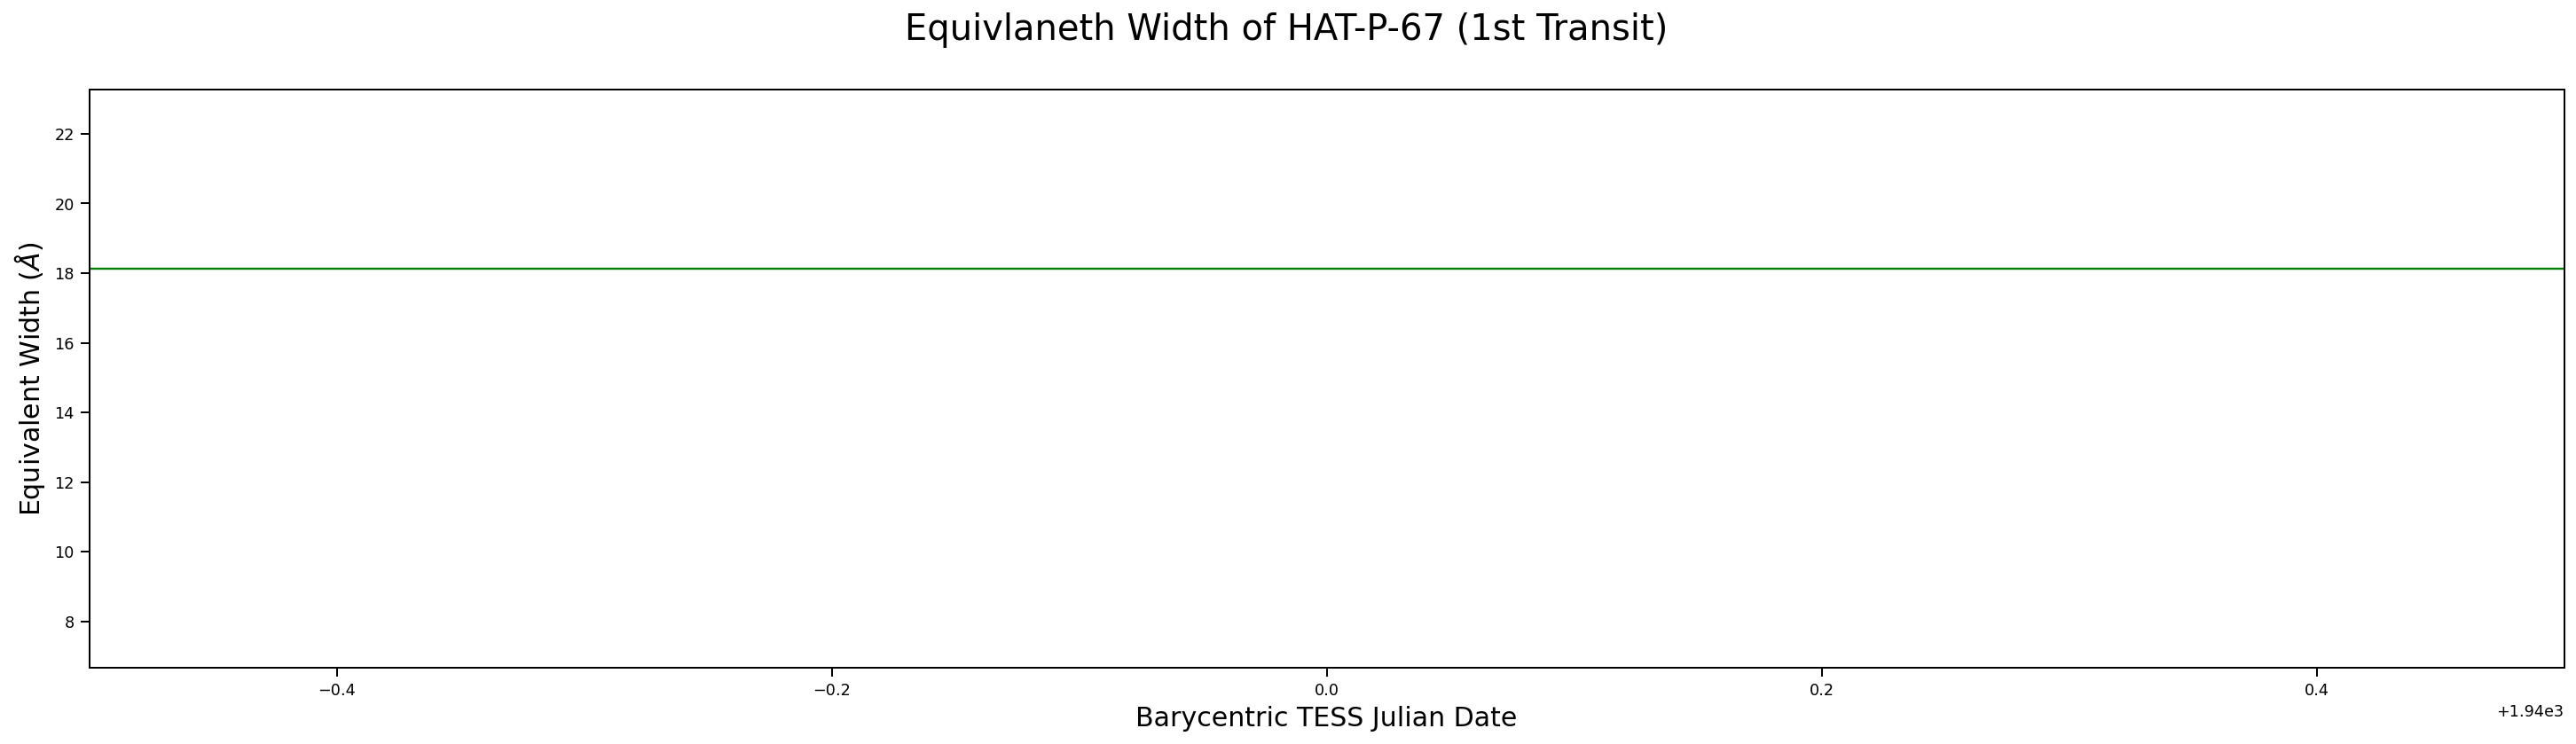

In [14]:
#1st in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(1.05,1.25)
plt.xlim(1939.5,1940.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (1st Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_1_{target_name}.jpg')

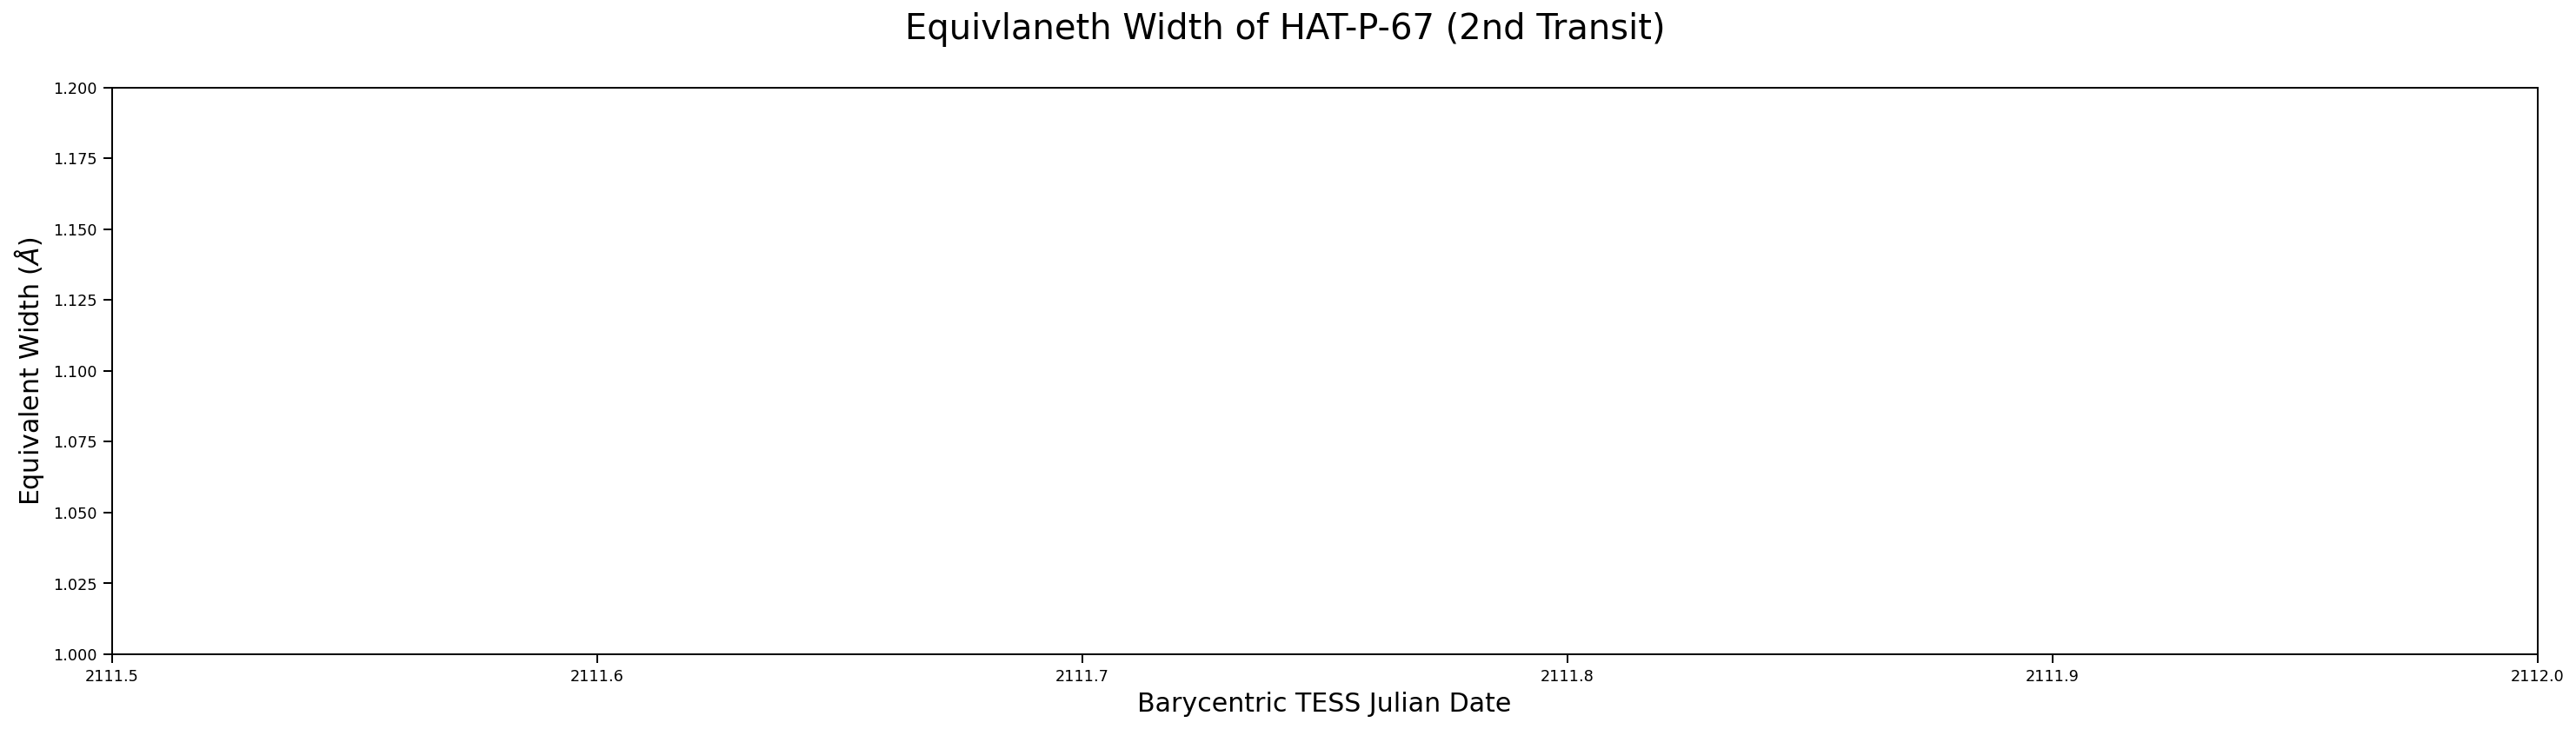

In [15]:
#2nd in transit plot
plt.figure(figsize=(25,6))
plt.errorbar(df.btjd, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.btjd[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
plt.ylim(1.0,1.2)
plt.xlim(2111.5,2112)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name} (2nd Transit)', fontsize=20)
plt.xlabel('Barycentric TESS Julian Date', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15) 
plt.savefig(f'../figures/IN_TRANSIT_2_{target_name}.jpg')

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [16]:
df['phase']=np.mod(df.btjd-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
#df['normalized_phase']=(df['phase']/orbital_period)-0.5

In [17]:
df.describe() #max less than orbital period, normalized less than 1

,ew,ew_unc,gaussian_width,gaussian_width_unc,int_wv,jd,n_samples,obs_line_center,obs_line_center_unc,qidx,btjd,phase
count,68.000000,68.000000,68.000000,68.000000,68.0,6.800000e+01,68.0,68.000000,68.000000,68.000000,68.000000,68.000000
mean,18.003135,2.923546,8.127487,1.512546,8542.0,2.458990e+06,5000.0,8533.851145,1.530214,6630.617647,1990.341135,0.006626
std,1.109423,1.039284,0.563049,0.332846,0.0,1.796788e+01,0.0,0.609094,0.467494,191.808131,17.967883,0.946003
min,14.572387,1.952871,6.467460,1.120811,8542.0,2.458967e+06,5000.0,8532.901547,1.097494,6436.000000,1966.770274,-1.915067
25%,17.716298,2.417047,7.923861,1.338082,8542.0,2.458969e+06,5000.0,8533.458828,1.316727,6437.750000,1968.532545,-0.162540
50%,18.127489,2.571832,8.184452,1.416624,8542.0,2.458992e+06,5000.0,8533.701664,1.395802,6587.000000,1991.712972,-0.008635
75%,18.687887,2.731080,8.485990,1.509278,8542.0,2.458999e+06,5000.0,8534.100426,1.488885,6684.500000,1998.929138,0.103631
max,19.777141,7.146584,9.060774,3.206001,8542.0,2.459017e+06,5000.0,8535.722295,4.248530,6943.000000,2016.873009,2.194709


In [18]:
plt.figure(figsize=(25,6))

plt.errorbar(df.normalized_phase, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

plt.errorbar(df.normalized_phase-1, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

plt.errorbar(df.normalized_phase+1, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
plt.xlim(-1.5,1.5)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

AttributeError: 'DataFrame' object has no attribute 'normalized_phase'

<Figure size 1800x432 with 0 Axes>

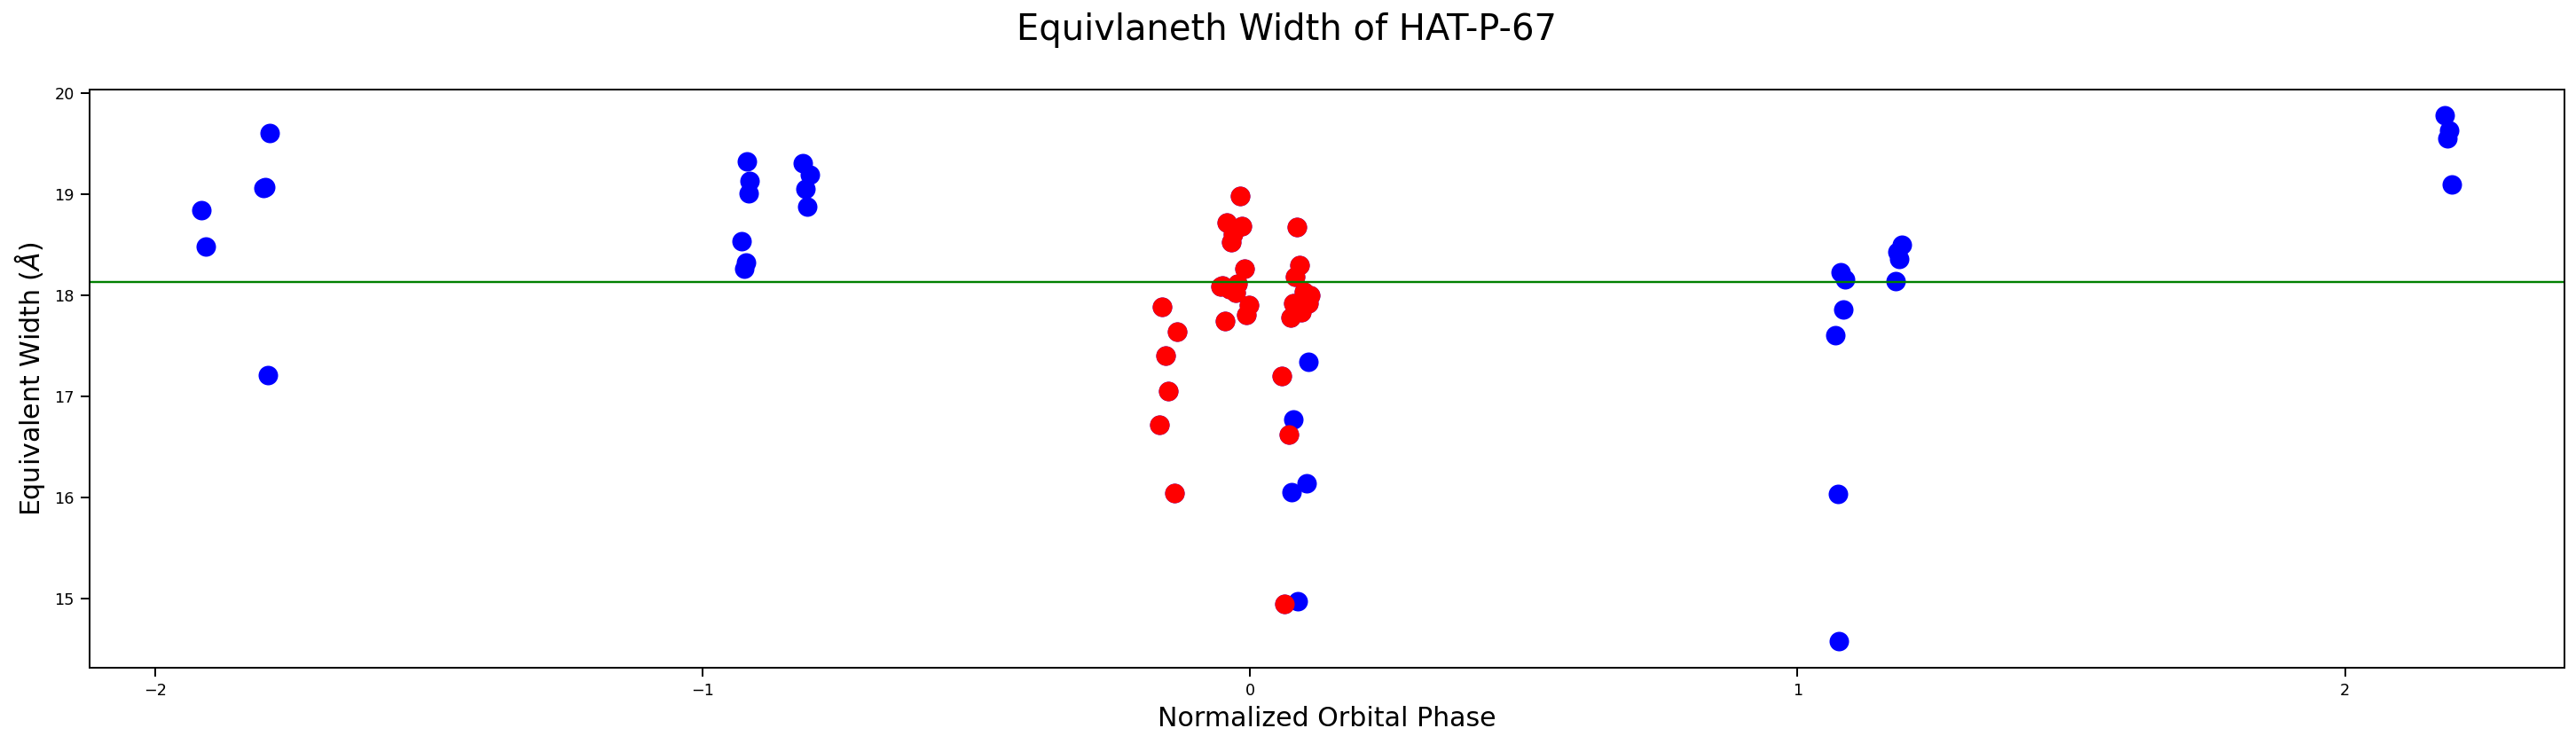

In [21]:
plt.figure(figsize=(25,6))

plt.plot(df.phase, df.ew, 'bo', markersize=10)
plt.plot(df.phase[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase-1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]-1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.plot(df.normalized_phase+1, df.ew, 'bo', markersize=10)
#plt.plot(df.normalized_phase[in_transit_mask]+1, df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time

#plt.ylim(0.9,1.32)
#plt.xlim(-2,2)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

Let's define a variable called 'shifted' in two steps.

In [ ]:
second_half_mask = df.normalized_phase > 0.5
first_half_mask = ~second_half_mask

In [ ]:
df['shifted']=df.normalized_phase
df.shifted[second_half_mask]=df.shifted[second_half_mask]-1
df.shifted[second_half_mask]

In [ ]:
plt.figure(figsize=(25,6))
plt.errorbar(df.shifted, df.ew, yerr=df.ew_unc, fmt='b.')
plt.plot(df.shifted[in_transit_mask], df.ew[in_transit_mask],'ro',markersize=10) #change index to jd for time
#plt.ylim(0.9,1.32)
plt.xlim(0,1)
plt.axhline(x_line,color = 'green')
plt.suptitle(f'Equivlaneth Width of {target_name}', fontsize=20)
plt.xlabel('Normalized Orbital Phase', fontsize=15)
plt.ylabel('Equivalent Width ($\AA$)', fontsize=15)
plt.savefig(f'../figures/{target_name}.jpg')

# Light curve analysis with TESS

In [25]:
sr = lk.search_lightcurve(target_name)
lc_raw = sr[1].download()

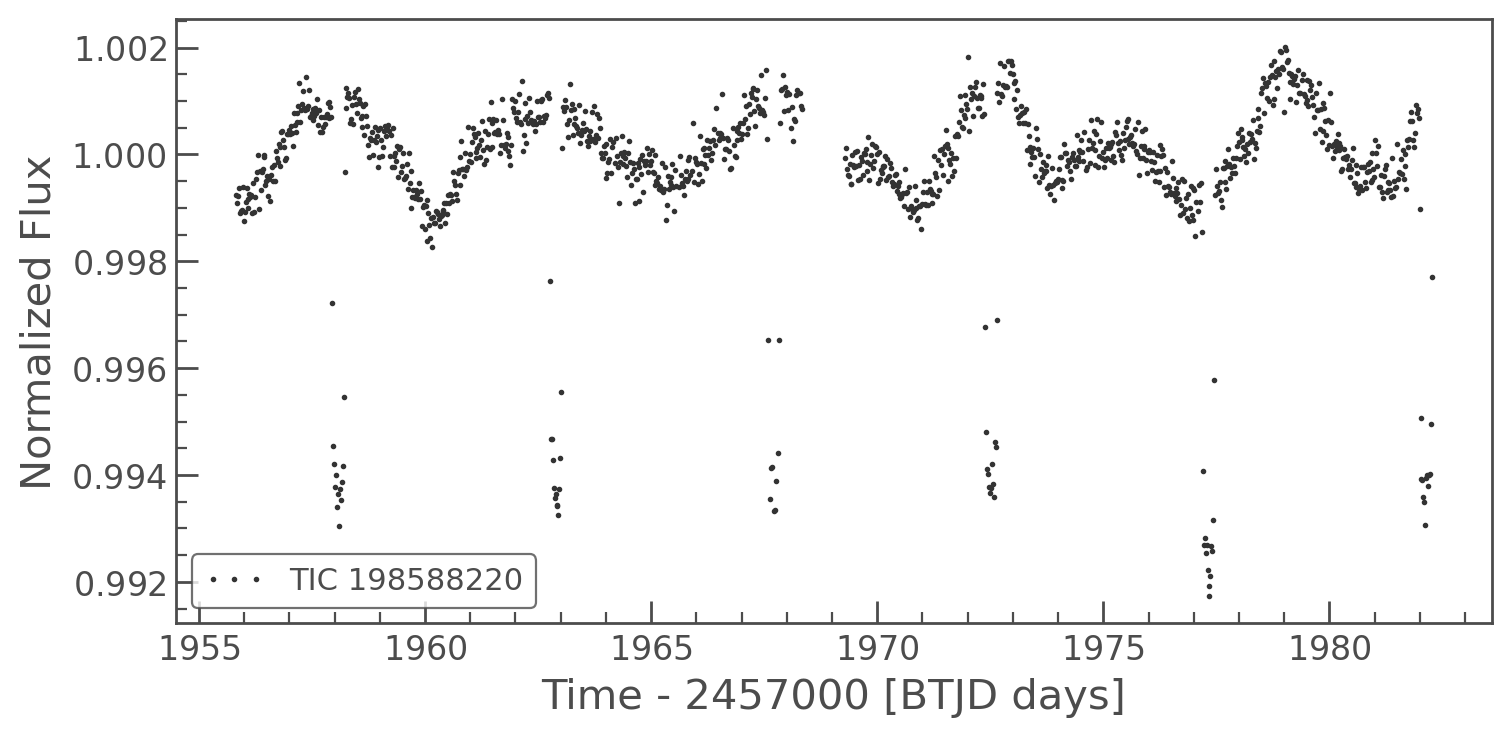

In [26]:
ax = lc_raw.normalize().plot(marker='.', linestyle='none')
#ax.set_ylim(0, 1.05)

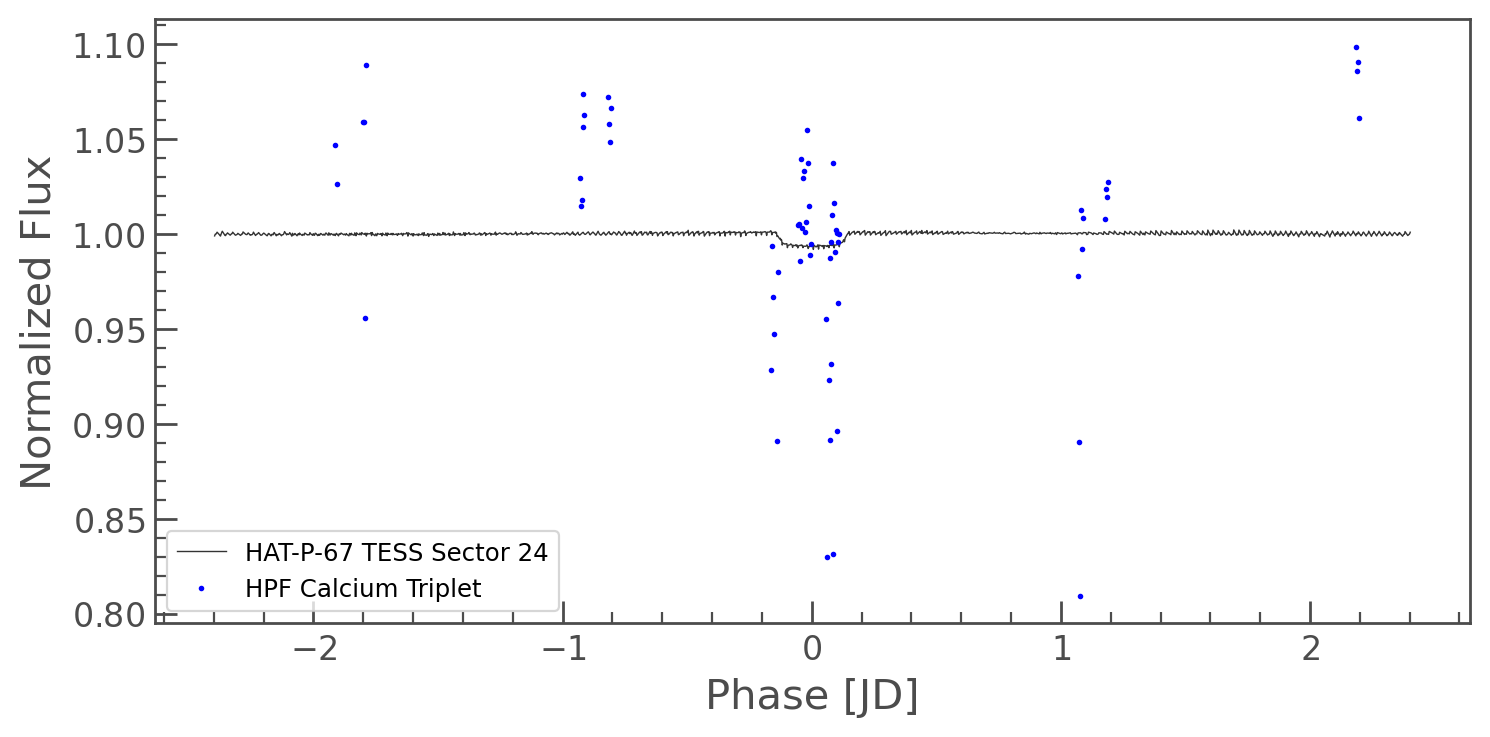

In [37]:
lc_folded = lc_raw.fold(period=orbital_period, epoch_time=t_c_btjd).normalize()
ax = lc_folded.plot(label = target_name+' TESS Sector 24')
plt.plot(df.phase, df.ew/np.mean(df.ew), 'bo', markersize=1, label = 'HPF Calcium Triplet')
plt.legend()
plt.savefig(f'../figures/TESS_EW_{target_name}.jpg')